In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import scib
import anndata 

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt


import seaborn as sns

import tissue.api as tissue

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [3]:
# user = "david.fischer"
# user = "ina"
user = "mayar.ali"

if user == "david.fischer":
    base_path_gcn = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/metabric/"
    base_path_mi = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/metabric/"
    base_path_reg = "/Users/david.fischer/phd/seafile/DavidFischer_notforFabian/tissue/grid_searches/metabric/"
elif user == "ina":
    base_path_gcn = '../../results/GCN/metabric/'
    base_path_reg = '../../results/REG/metabric/'
    
elif user == "mayar.ali":
    base_path_gcn = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/metabric/"
    base_path_mi = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/metabric/"
    base_path_reg = "/home/iterm/mayar.ali/phd/projects/tissue/grid_searches/refactor/metabric/"


# Overall

In [4]:
dir_figures="/storage/groups/ml01/workspace/mayar.ali/tissue/figures/metabric/"

In [7]:
def get_cells_features(layer_name, interpreter):
    # get features of cells

    if layer_name == 'input':
        h = [interpreter.h[image_key] for image_key in interpreter.img_keys_test]
    else:
        acts = interpreter._get_node_embeddings(
        idx=interpreter.img_keys_test,
        layers=[layer_name]
        )
        h = acts[layer_name]
        
    cells = np.concatenate(h)
    cells = cells[:, cells.std(axis=0) > 0]
    cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)

    images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

    adata_cells = anndata.AnnData(
        cells,
        obs=pd.DataFrame({
            "images": images,
        })
    )

    adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])
    return adata_cells

In [8]:
def get_intergation_metrics(adata_cells, model, cvx):
    
    metrics = [model, cvx]
    from sklearn.linear_model import LogisticRegression
    logreg = LogisticRegression()
    logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

    print(f"{layer_name=}")
    image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
    print(f'Images training score: {image_score}')
    metrics.append(image_score)



    from sklearn.metrics import explained_variance_score, r2_score

    explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                               logreg.predict(adata_cells.X))
    print(f'Variance explained - images : {explained_variance_score_images}')
    metrics.append(explained_variance_score_images)

    r2_score_images = r2_score(adata_cells.obs["images_label"], 
                               logreg.predict(adata_cells.X), 
                               multioutput='uniform_average')
    print(f'R2 score - images: {r2_score_images}')
    metrics.append(r2_score_images)
    
    n_neighbors=50
    sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
    sc.tl.pca(adata_cells)

    label_key="images"
    graph_conn = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
    metrics.append(graph_conn)
    print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_conn}')

    label_key="images"
    ilisi = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
    metrics.append(ilisi)
    print(f'ilisi graph  metric {layer_name} layer - {label_key} = {ilisi}')

    df = pd.DataFrame(columns=["model", "cv", "prediction_score", "variance_explained", 
                               "r2_score", "graph_connectivity", "ilisi"])
    df.loc[0] = metrics
    return df

#### GCN SS

In [5]:
container_gcnss = tissue.fits.GridSearchContainer(
    source_path={
        "2205191157_GCNSS_NONE_GRADE_STANDARD_metabric_RADIUS_TRANSFORM_KEY_1_best_model_train": base_path_gcn,
    },
    gs_ids=[
        "2205191157_GCNSS_NONE_GRADE_STANDARD_metabric_RADIUS_TRANSFORM_KEY_1_best_model_train",
        
    ]
)
container_gcnss.load_gs()

loaded 2205191157_GCNSS_NONE_GRADE_STANDARD_metabric_RADIUS_TRANSFORM_KEY_1_best_model_train: 1 runs with 3-fold cross validation


In [6]:
gs_id, model_id, cv = container_gcnss.get_best_model_id(partition_select='val')
container_gcnss.get_info(gs_id = gs_id, model_id=model_id)
print(model_id)
container_gcnss.runparams[gs_id][model_id]

gcnss_none_metabric_gradeadam_lr2_dr1_drp1_l21_de2_wi4_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe2_fpmean_mtsmall_nc1_ew1_nh1_ssmultitask


{'model_id': 'gcnss_none_metabric_gradeadam_lr2_dr1_drp1_l21_de2_wi4_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe2_fpmean_mtsmall_nc1_ew1_nh1_ssmultitask',
 'model_class': 'gcnss',
 'gs_id': '2205191157_gcnss_none_grade_standard_metabric_radius_transform_key_1_best_model_train',
 'data_set': 'metabric',
 'max_dist': 20,
 'target_label': 'grade',
 'graph_label_selection': ['ERstatus',
  'grade',
  'time_last_seen',
  'tumor_size'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.005,
 'depth_feature_embedding': 2,
 'depth': 2,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 0.0,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 5,
 'entropy_weight': 0.0001,
 'numb

In [9]:
df_metrics = pd.DataFrame(columns=["model", "cv", "prediction_score", "variance_explained", "r2_score", "graph_connectivity", "ilisi"])
df_metrics

Empty DataFrame
Columns: [model, cv, prediction_score, variance_explained, r2_score, graph_connectivity, ilisi]
Index: []

In [10]:
models = {
    'input': 'input',
    'Layer_gcn_1': 'GCNSS'
}
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCNSS")
    interpreter.load_model()

    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/refactored/metabric/"
    interpreter.get_data_again(
        data_path=data_path,
        buffered_data_path=buffered_data_path,
    )

    for layer_name in ['input', 'Layer_gcn_1']:
        print(f"{layer_name=}")
        adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
        df = get_intergation_metrics(adata_cells, models[layer_name], cvx)
        df_metrics = pd.concat([df_metrics, df], ignore_index=True)
    

cv0


2022-06-02 11:40:18.026761: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 11:40:18.026839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: supergpu05.scidom.de
2022-06-02 11:40:18.026853: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: supergpu05.scidom.de
2022-06-02 11:40:18.026976: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-06-02 11:40:18.027026: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-06-02 11:40:18.027032: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2022-06-02 11:40:18.027412: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.7417238571594742
Variance explained - images : 0.500851997355277
R2 score - images: 0.5004942336508944
graph connectivity metric input layer - images = 0.9551350166221545
/tmp/lisi_e7rrj6os/input.mtx /tmp/lisi_e7rrj6os/
ilisi graph  metric input layer - images = 0.06635923362890296
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63f822e580>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_gcn_1'
Images training score: 0.664534139816215
Variance explained - images : 0.34197398856595596
R2 score - images: 0.34115212913167225
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


graph connectivity metric Layer_gcn_1 layer - images = 0.8592187081668657
/tmp/lisi_q3wf1v30/input.mtx /tmp/lisi_q3wf1v30/
ilisi graph  metric Layer_gcn_1 layer - images = 0.06172972077064686
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.7417238571594742
Variance explained - images : 0.500851997355277
R2 score - images: 0.5004942336508944
graph connectivity metric input layer - images = 0.9551350166221545
/tmp/lisi_q5lzkzq2/input.mtx /tmp/lisi_q5lzkzq2/
ilisi graph  metric input layer - images = 0.06635923362890296
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63f833ae20>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_gcn_1'
Images training score: 0.7205071536582529
Variance explained - images : 0.4248023029882966
R2 score - images: 0.4218580919697734
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


graph connectivity metric Layer_gcn_1 layer - images = 0.8891286370033913
/tmp/lisi_s8h25obu/input.mtx /tmp/lisi_s8h25obu/
ilisi graph  metric Layer_gcn_1 layer - images = 0.04856492759517147
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='input'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.7417238571594742
Variance explained - images : 0.500851997355277
R2 score - images: 0.5004942336508944
graph connectivity metric input layer - images = 0.9551350166221545
/tmp/lisi_citrwvv4/input.mtx /tmp/lisi_citrwvv4/
ilisi graph  metric input layer - images = 0.06635923362890296
layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63ed75b2e0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_gcn_1'
Images training score: 0.6971966965220425
Variance explained - images : 0.4012336701591511
R2 score - images: 0.39660832736845775
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


graph connectivity metric Layer_gcn_1 layer - images = 0.9017702660922013
/tmp/lisi_bomlhp44/input.mtx /tmp/lisi_bomlhp44/
ilisi graph  metric Layer_gcn_1 layer - images = 0.04652636565379552


In [7]:
interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="GCNSS")
interpreter.load_model()

data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/"
buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/"
interpreter.get_data_again(
    data_path=data_path,
)

2022-06-02 09:42:58.561760: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-06-02 09:42:58.561866: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: supergpu05.scidom.de
2022-06-02 09:42:58.561876: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: supergpu05.scidom.de
2022-06-02 09:42:58.562002: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2022-06-02 09:42:58.562048: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2022-06-02 09:42:58.562056: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2022-06-02 09:42:58.562821: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the follow

/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:234: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpos


Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.



/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f69e0998a60>
/home/iterm/mayar.ali/phd/projects/tissue/tissue/interpretation/interpreter.py:371: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  labels = list(np.array(labels)[[[l in label_names for l in labels]]])


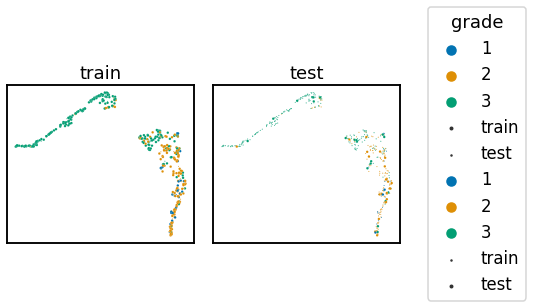

In [8]:
interpreter.plot_umap_graphs(
    label='grade',
    data_key='mb',
#     save='fig3c_refactored'
)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc47c2cb4c0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc45969b100>


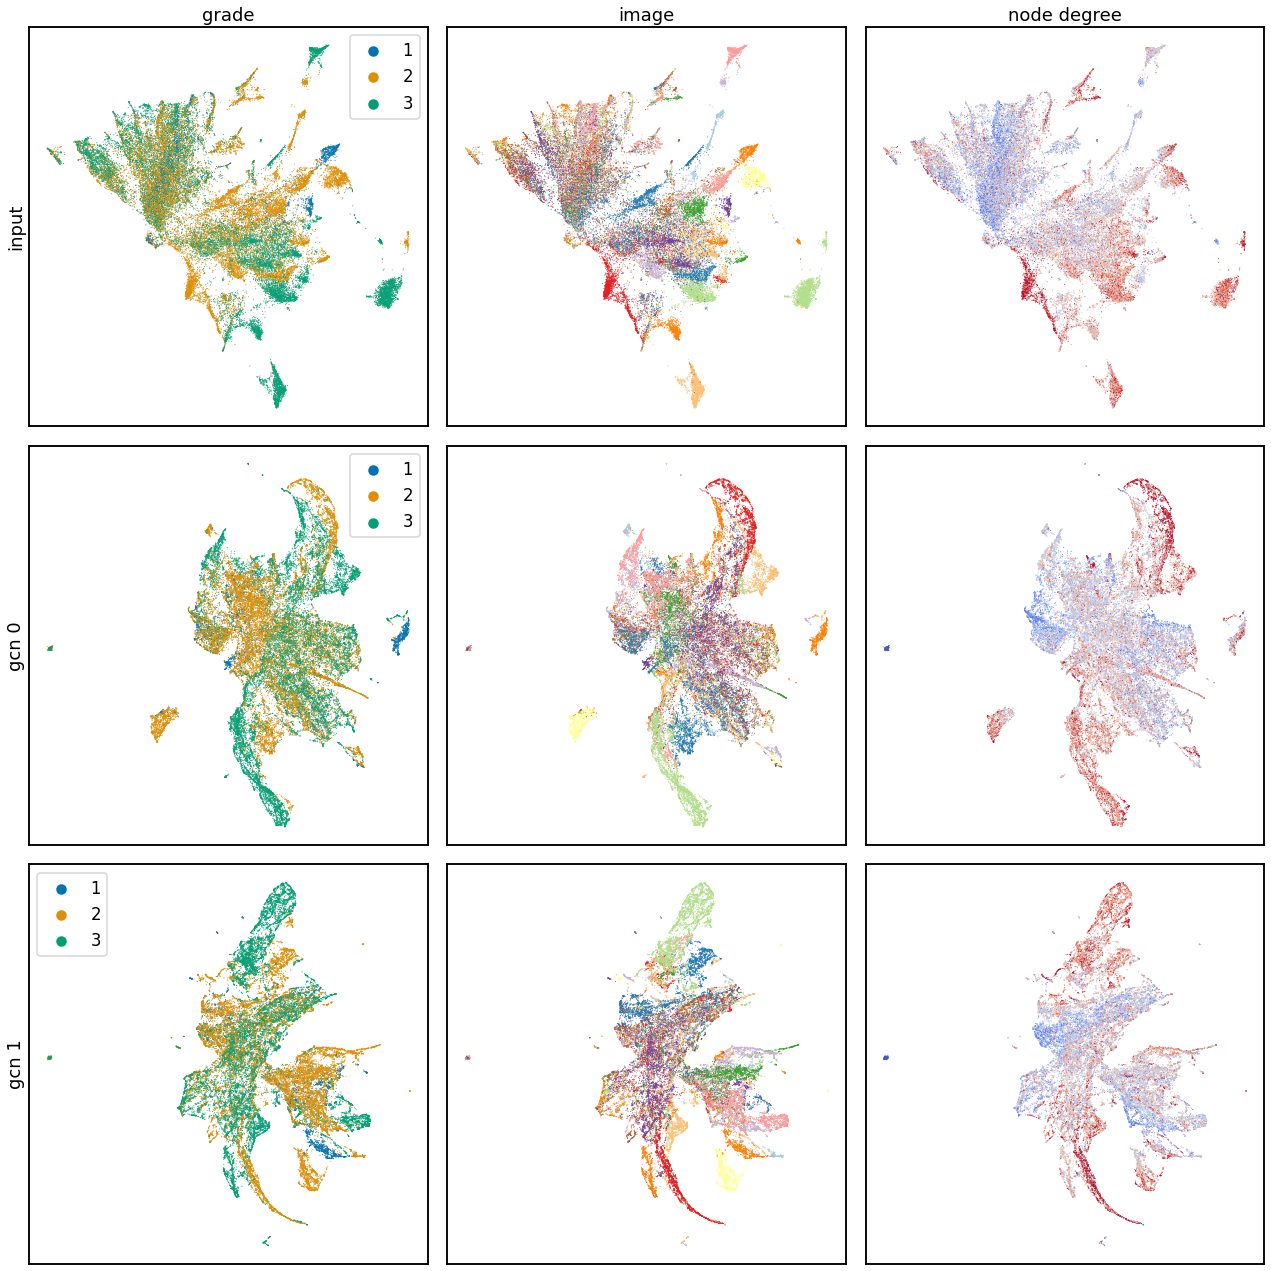

In [13]:
interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_gcn_0',
        'Layer_gcn_1',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='mb',
#     save=dir_figures+"supp_gcnss_std_node_emb_refactored", 
)

In [9]:
# get features of cells

layer_name = 'input'
h = [interpreter.h[image_key] for image_key in interpreter.img_keys_test]

cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)

images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
predict_score_images_cells = []

varian_explained_images_cells = []
r2_images_cells = []
r2_linreg_images_cells = []

In [11]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

layer_name='input'
Images training score: 0.7417238571594742
Variance explained - images : 0.500851997355277
R2 score - images: 0.5004942336508944
R2 score linreg - images: 0.5592187298708488


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
graph_connectivity_cells = []
ilisi_cells_images = []

In [13]:
n_neighbors=50
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric input layer - images = 0.9551350166221545
/tmp/lisi_972xtrue/input.mtx /tmp/lisi_972xtrue/
ilisi graph  metric input layer - images = 0.06635923362890296


In [14]:
layer_name = 'Layer_gcn_1'
acts = interpreter._get_node_embeddings(
        idx=interpreter.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter.h[id].shape[0] for id in interpreter.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f699b340ee0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_gcn_1'
Images training score: 0.694474816796557
Variance explained - images : 0.39091870122291406
R2 score - images: 0.3862645063618251
R2 score linreg - images: 0.47468884467918687


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

         Falling back to preprocessing with `sc.pp.pca` and default params.
graph connectivity metric Layer_gcn_1 layer - images = 0.902363509887196
/tmp/lisi_mdt8_coq/input.mtx /tmp/lisi_mdt8_coq/
ilisi graph  metric Layer_gcn_1 layer - images = 0.04632875641045955


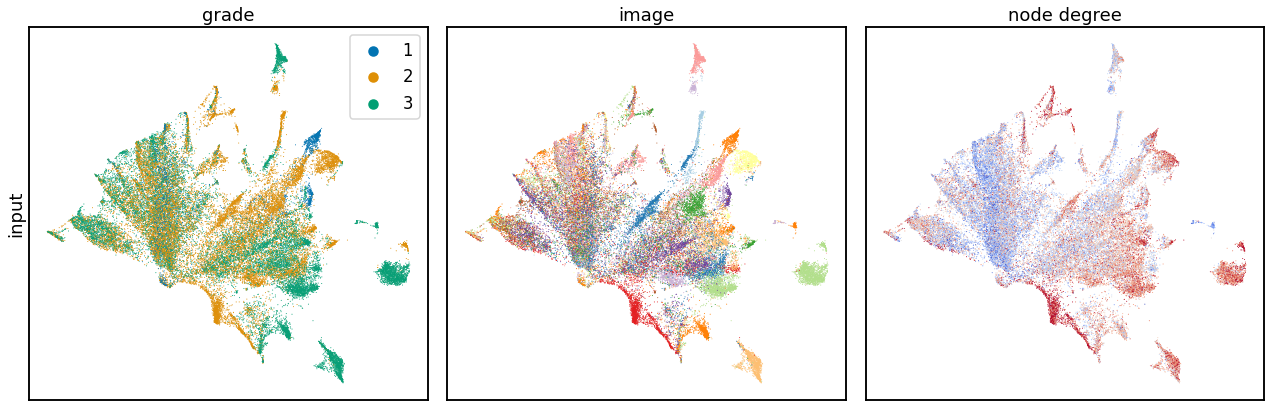

In [16]:
n_neighbors=50
layer_name = 'input'
umap_emb, hue = interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='mb',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [17]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [18]:
predict_score_images = []
predict_score_grade = []

varian_explained_images = []
r2_images = []
r2_linreg_images = []

In [19]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='input'
Images training score: 0.23982784692334536
Grade training score: 0.5945097126904734
Variance explained - images : -0.25297613211902115
R2 score - images: -0.2596025901379282
R2 score linreg - images: 0.0687779461882444


In [20]:
graph_conn_grade = []
ilsi_graph_grade = []

graph_conn_images = []
ilsi_graph_images = []

In [21]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric input layer - grade = 0.7167628646472158
graph connectivity metric input layer - images = 0.4379950204427942
/tmp/lisi_z0ot38f7/input.mtx /tmp/lisi_z0ot38f7/
ilisi graph metric input layer - grade = 0.3383827391267116
/tmp/lisi_rjz0gac2/input.mtx /tmp/lisi_rjz0gac2/
ilisi graph  metric input layer - images = 0.07564360233483494


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6994b9b400>


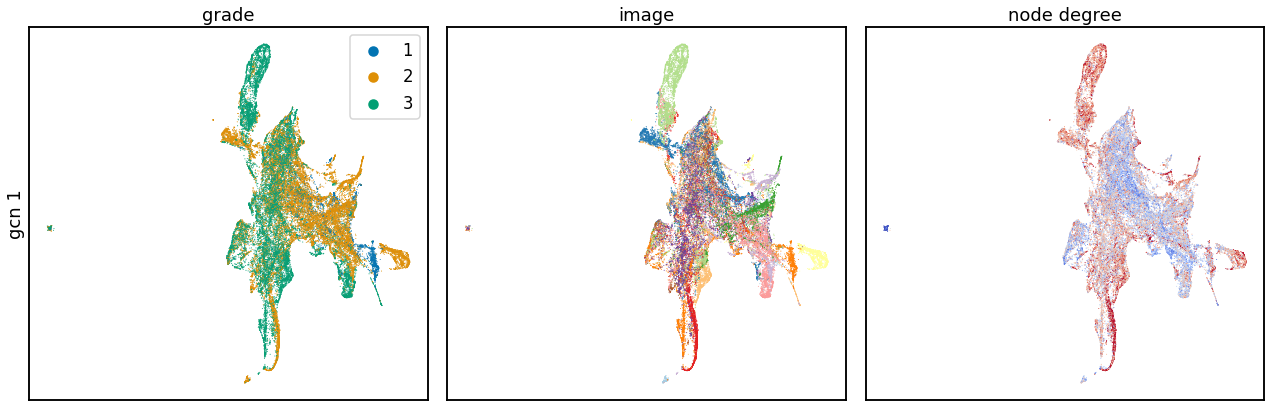

In [22]:
n_neighbors=50
layer_name = 'Layer_gcn_1'
umap_emb, hue = interpreter.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='mb',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [23]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [24]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_gcn_1'
Images training score: 0.2602535768291264
Grade training score: 0.5869954635337908
Variance explained - images : -0.5863842911518378
R2 score - images: -0.6216266617755226
R2 score linreg - images: 0.032470404746314595


In [25]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - grade = 0.8087825630891503
graph connectivity metric Layer_gcn_1 layer - images = 0.48474039701503674
/tmp/lisi_cugowfn6/input.mtx /tmp/lisi_cugowfn6/
20788 has not enough neighbors.
20797 has not enough neighbors.
20798 has not enough neighbors.
20804 has not enough neighbors.
20810 has not enough neighbors.
20813 has not enough neighbors.
20821 has not enough neighbors.
20832 has not enough neighbors.
20836 has not enough neighbors.
20844 has not enough neighbors.
20847 has not enough neighbors.
20850 has not enough neighbors.
20861 has not enough neighbors.
20871 has not enough neighbors.
ilisi graph metric Layer_gcn_1 layer - grade = 0.2488891746271642
/tmp/lisi_7tubj9og/input.mtx /tmp/lisi_7tubj9og/
20788 has not enough neighbors.
20797 has not enough neighbors.
20798 has not enough neighbors.
20804 has not enough neighbors.
20810 has not enough neighbors.
20813 has not enough neighbors.
20821 has not enough neighbors.
20832 has not en

#### GCN

In [12]:
container_gcn = tissue.fits.GridSearchContainer(
    source_path={
        "2205191200_GCN_NONE_GRADE_STANDARD_metabric_RADIUS_TRANSFORM_KEY_1_best_model": base_path_gcn,
    },
    gs_ids=[
        "2205191200_GCN_NONE_GRADE_STANDARD_metabric_RADIUS_TRANSFORM_KEY_1_best_model",
        
    ]
)
container_gcn.load_gs()

loaded 2205191200_GCN_NONE_GRADE_STANDARD_metabric_RADIUS_TRANSFORM_KEY_1_best_model: 1 runs with 3-fold cross validation


In [13]:
gs_id, model_id, cv = container_gcn.get_best_model_id(partition_select='val')
container_gcn.get_info(gs_id = gs_id, model_id=model_id)
print(model_id)
container_gcn.runparams[gs_id][model_id]

gcn_none_metabric_gradeadam_lr3_dr1_drp1_l21_de2_wi3_lw1_lt1_bs2_md3_tk1_ck1_fsstandard_fe2_fpmean_mtsmall_nc1_ew1_nh1_ssnone


{'model_id': 'gcn_none_metabric_gradeadam_lr3_dr1_drp1_l21_de2_wi3_lw1_lt1_bs2_md3_tk1_ck1_fsstandard_fe2_fpmean_mtsmall_nc1_ew1_nh1_ssnone',
 'model_class': 'gcn',
 'gs_id': '2205191200_gcn_none_grade_standard_metabric_radius_transform_key_1_best_model',
 'data_set': 'metabric',
 'max_dist': 55,
 'target_label': 'grade',
 'graph_label_selection': ['ERstatus',
  'grade',
  'time_last_seen',
  'tumor_size'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.0005,
 'depth_feature_embedding': 2,
 'depth': 2,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 0.0,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 5,
 'entropy_weight': 0.0001,
 'number_heads': 1,
 '

In [14]:
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cvx, model_id=model_id, model_class="GCN")
    interpreter.load_model()

    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    interpreter.get_data_again(
        data_path=data_path,
    )

    layer_name='Layer_gcn_1'
    print(f"{layer_name=}")
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "GCN", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)


cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_55_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63f853f940>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.9661044550424567
Variance explained - images : 0.950230314794196
R2 score - images: 0.9501927767504438
graph connectivity metric Layer_gcn_1 layer - images = 0.9892335564465806
/tmp/lisi_pivpph6k/input.mtx /tmp/lisi_pivpph6k/
ilisi graph  metric Layer_gcn_1 layer - images = 0.0015592668648564297
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_55_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63a510c820>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.961567988833314
Variance explained - images : 0.9251303817632182
R2 score - images: 0.9251251105088683
graph connectivity metric Layer_gcn_1 layer - images = 0.990206959087502
/tmp/lisi_m_mhbdmj/input.mtx /tmp/lisi_m_mhbdmj/
ilisi graph  metric Layer_gcn_1 layer - images = 0.004131804990754616
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_55_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='Layer_gcn_1'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f63935db640>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:

layer_name='Layer_gcn_1'
Images training score: 0.9631266720949169
Variance explained - images : 0.9333901692713824
R2 score - images: 0.9333898997449684
graph connectivity metric Layer_gcn_1 layer - images = 0.987929813548232
/tmp/lisi_6on__ehs/input.mtx /tmp/lisi_6on__ehs/
ilisi graph  metric Layer_gcn_1 layer - images = 0.002294689757604878


In [28]:
interpreter_gcn = tissue.fits.InterpreterGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="GCN")
interpreter_gcn.load_model()

interpreter_gcn.get_data_again(
    data_path=data_path,
)

/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_55_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.



/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc4595a5760>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc47ca038e0>


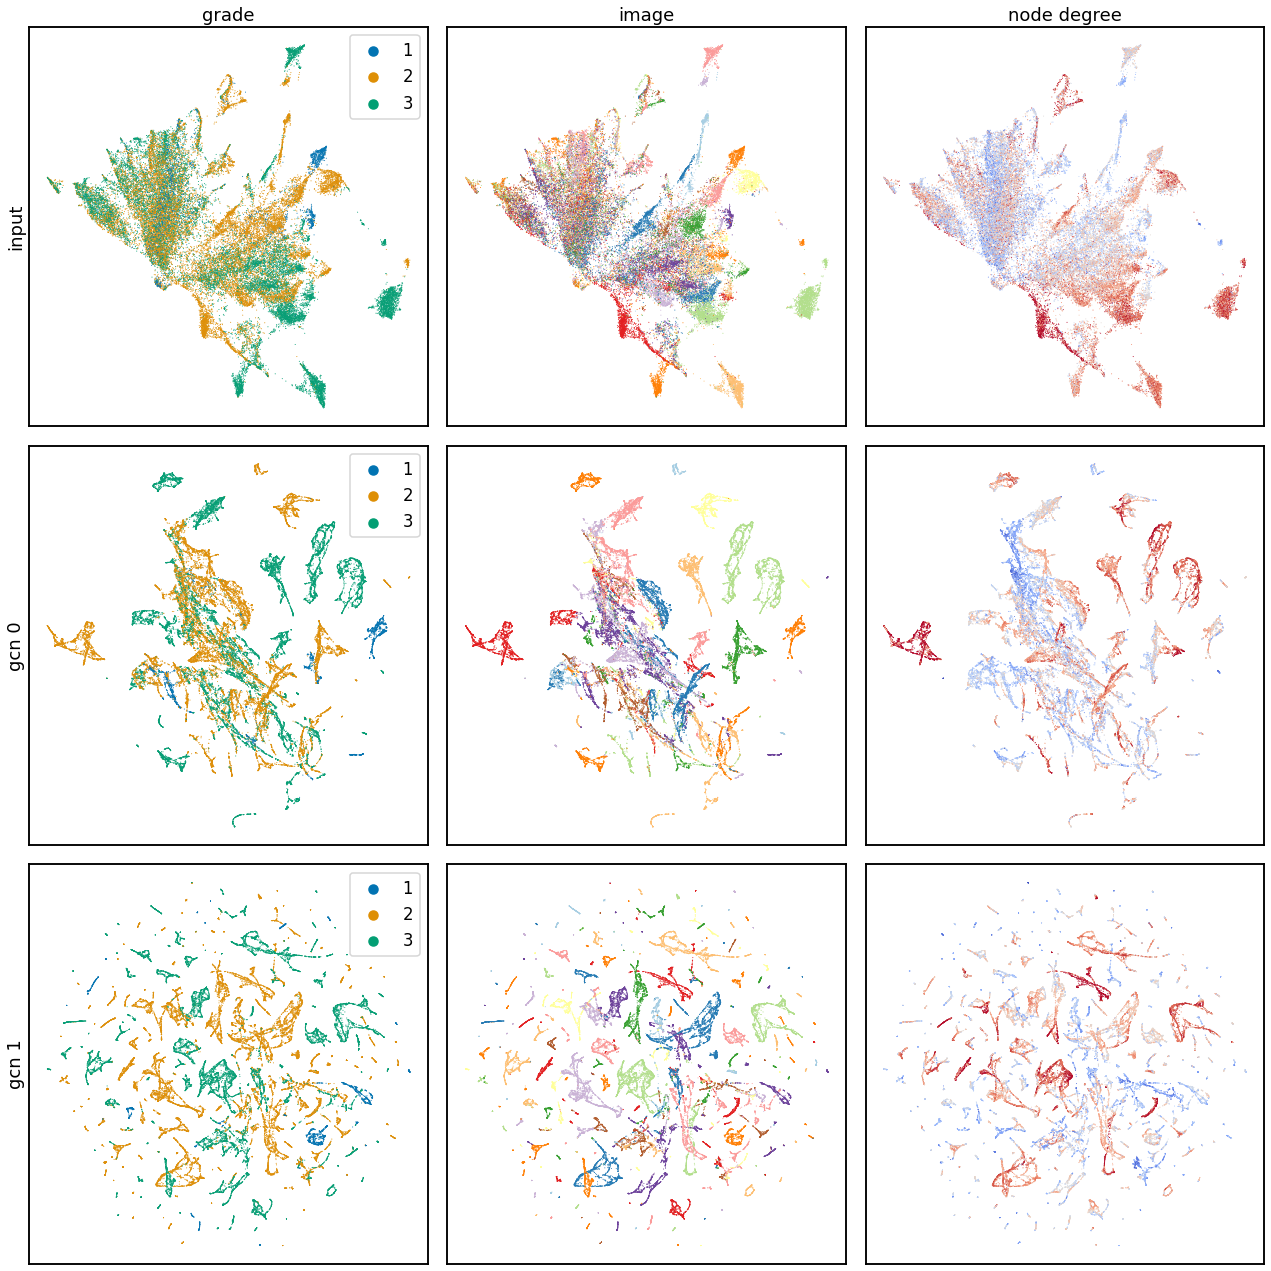

In [36]:
interpreter_gcn.plot_umap_nodes(
    interpreter.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_gcn_0',
        'Layer_gcn_1',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='mb',
    save=dir_figures+"supp_gcn_std_node_emb_refactored", 
)

In [29]:
layer_name = 'Layer_gcn_1'
acts = interpreter_gcn._get_node_embeddings(
        idx=interpreter_gcn.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter_gcn.h[id].shape[0] for id in interpreter_gcn.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f699b70d1c0>
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_gcn_1'
Images training score: 0.961567988833314
Variance explained - images : 0.9251303817632182
R2 score - images: 0.9251251105088683
R2 score linreg - images: 0.9263628197261156


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - images = 0.990206959087502
/tmp/lisi_j5gce5oq/input.mtx /tmp/lisi_j5gce5oq/
ilisi graph  metric Layer_gcn_1 layer - images = 0.004131804990754616


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/numpy/matrixlib/defmatrix.py:71: PendingDeprecationWarning: the matrix subclass is not the recommended way to represent matrices or deal with linear algebra (see https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html). Please adjust your code to use regular ndarray.
  return matrix(data, dtype=dtype, copy=False)
sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f6994cceca0>


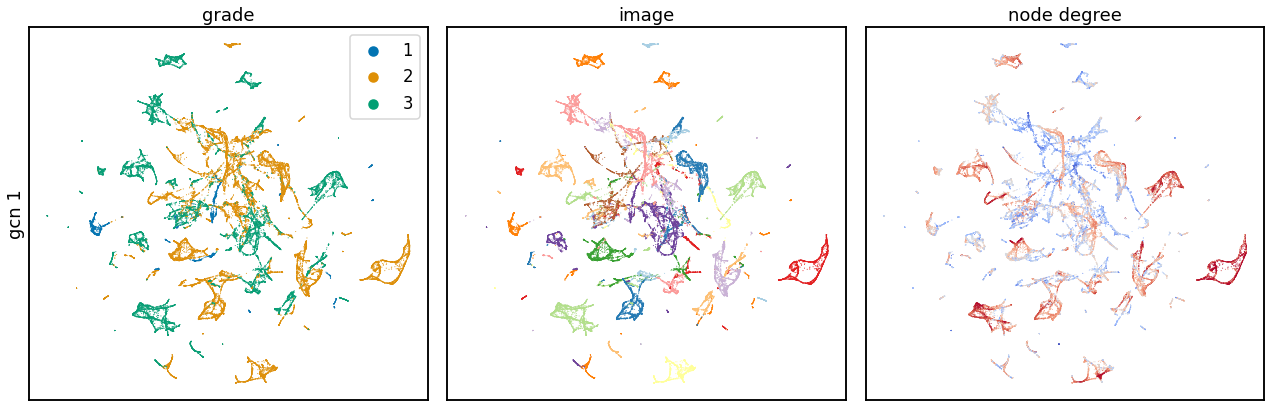

In [31]:
n_neighbors=50
layer_name = 'Layer_gcn_1'
umap_emb, hue = interpreter_gcn.plot_umap_nodes(
    interpreter_gcn.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='mb',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [32]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [33]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_gcn_1'
Images training score: 0.5306734907525881
Grade training score: 0.613144120041875
Variance explained - images : 0.2114217846053009
R2 score - images: 0.13970695112161813
R2 score linreg - images: 0.3511255685548969


In [34]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_gcn_1 layer - grade = 0.3474401273605901
graph connectivity metric Layer_gcn_1 layer - images = 0.7556424554207808
/tmp/lisi_ij_1q1vq/input.mtx /tmp/lisi_ij_1q1vq/
234 has not enough neighbors.
259 has not enough neighbors.
269 has not enough neighbors.
392 has not enough neighbors.
396 has not enough neighbors.
410 has not enough neighbors.
415 has not enough neighbors.
419 has not enough neighbors.
424 has not enough neighbors.
427 has not enough neighbors.
428 has not enough neighbors.
437 has not enough neighbors.
440 has not enough neighbors.
443 has not enough neighbors.
444 has not enough neighbors.
445 has not enough neighbors.
452 has not enough neighbors.
454 has not enough neighbors.
458 has not enough neighbors.
459 has not enough neighbors.
465 has not enough neighbors.
466 has not enough neighbors.
477 has not enough neighbors.
483 has not enough neighbors.
489 has not enough neighbors.
494 has not enough neighbors.
496 has not enough neigh

31563 has not enough neighbors.
31566 has not enough neighbors.
31568 has not enough neighbors.
31573 has not enough neighbors.
31575 has not enough neighbors.
31577 has not enough neighbors.
31578 has not enough neighbors.
31579 has not enough neighbors.
31585 has not enough neighbors.
31589 has not enough neighbors.
31591 has not enough neighbors.
31593 has not enough neighbors.
31594 has not enough neighbors.
31595 has not enough neighbors.
31596 has not enough neighbors.
31602 has not enough neighbors.
31603 has not enough neighbors.
31604 has not enough neighbors.
31605 has not enough neighbors.
31609 has not enough neighbors.
31610 has not enough neighbors.
31617 has not enough neighbors.
31621 has not enough neighbors.
31627 has not enough neighbors.
31629 has not enough neighbors.
31634 has not enough neighbors.
31635 has not enough neighbors.
31641 has not enough neighbors.
31645 has not enough neighbors.
31646 has not enough neighbors.
31658 has not enough neighbors.
31662 ha

41225 has not enough neighbors.
41230 has not enough neighbors.
41404 has not enough neighbors.
41414 has not enough neighbors.
41415 has not enough neighbors.
41457 has not enough neighbors.
41466 has not enough neighbors.
41474 has not enough neighbors.
41483 has not enough neighbors.
41493 has not enough neighbors.
41497 has not enough neighbors.
41504 has not enough neighbors.
41507 has not enough neighbors.
41649 has not enough neighbors.
41654 has not enough neighbors.
41655 has not enough neighbors.
41656 has not enough neighbors.
41657 has not enough neighbors.
41658 has not enough neighbors.
41661 has not enough neighbors.
41664 has not enough neighbors.
41665 has not enough neighbors.
41668 has not enough neighbors.
41670 has not enough neighbors.
41672 has not enough neighbors.
41673 has not enough neighbors.
41675 has not enough neighbors.
41676 has not enough neighbors.
41677 has not enough neighbors.
41679 has not enough neighbors.
41680 has not enough neighbors.
41684 ha

3701 has not enough neighbors.
3709 has not enough neighbors.
3710 has not enough neighbors.
3720 has not enough neighbors.
3721 has not enough neighbors.
3724 has not enough neighbors.
3729 has not enough neighbors.
3731 has not enough neighbors.
3735 has not enough neighbors.
3747 has not enough neighbors.
3759 has not enough neighbors.
3760 has not enough neighbors.
3764 has not enough neighbors.
3768 has not enough neighbors.
3769 has not enough neighbors.
3774 has not enough neighbors.
3786 has not enough neighbors.
3787 has not enough neighbors.
3796 has not enough neighbors.
3801 has not enough neighbors.
3820 has not enough neighbors.
3827 has not enough neighbors.
3834 has not enough neighbors.
3841 has not enough neighbors.
3844 has not enough neighbors.
3846 has not enough neighbors.
3857 has not enough neighbors.
3865 has not enough neighbors.
3873 has not enough neighbors.
3874 has not enough neighbors.
3878 has not enough neighbors.
3879 has not enough neighbors.
3880 has

32344 has not enough neighbors.
32345 has not enough neighbors.
32346 has not enough neighbors.
32349 has not enough neighbors.
32350 has not enough neighbors.
32351 has not enough neighbors.
32352 has not enough neighbors.
32354 has not enough neighbors.
32355 has not enough neighbors.
32357 has not enough neighbors.
32358 has not enough neighbors.
32359 has not enough neighbors.
32515 has not enough neighbors.
33722 has not enough neighbors.
38367 has not enough neighbors.
38394 has not enough neighbors.
38412 has not enough neighbors.
38415 has not enough neighbors.
38420 has not enough neighbors.
38426 has not enough neighbors.
38435 has not enough neighbors.
38439 has not enough neighbors.
38446 has not enough neighbors.
38447 has not enough neighbors.
38449 has not enough neighbors.
38453 has not enough neighbors.
38463 has not enough neighbors.
38467 has not enough neighbors.
38472 has not enough neighbors.
38474 has not enough neighbors.
38480 has not enough neighbors.
38490 ha

42406 has not enough neighbors.
42410 has not enough neighbors.
42411 has not enough neighbors.
42419 has not enough neighbors.
42429 has not enough neighbors.
42433 has not enough neighbors.
42435 has not enough neighbors.
42443 has not enough neighbors.
42450 has not enough neighbors.
42451 has not enough neighbors.
42464 has not enough neighbors.
42465 has not enough neighbors.
42467 has not enough neighbors.
42474 has not enough neighbors.
42480 has not enough neighbors.
42484 has not enough neighbors.
42488 has not enough neighbors.
42495 has not enough neighbors.
42503 has not enough neighbors.
42506 has not enough neighbors.
42513 has not enough neighbors.
42521 has not enough neighbors.
42525 has not enough neighbors.
42560 has not enough neighbors.
ilisi graph  metric Layer_gcn_1 layer - images = 2.0452653367956468e-07


#### MI

In [15]:
container_mi = tissue.fits.GridSearchContainer(
    source_path={
        "2205191203_MI_NONE_GRADE_STANDARD_metabric_RADIUS_best_model": base_path_mi,
    },
    gs_ids=[
        "2205191203_MI_NONE_GRADE_STANDARD_metabric_RADIUS_best_model", 
        
    ]
)
container_mi.load_gs()

loaded 2205191203_MI_NONE_GRADE_STANDARD_metabric_RADIUS_best_model: 1 runs with 3-fold cross validation


In [16]:
gs_id, model_id, cv = container_mi.get_best_model_id(partition_select='val')
container_mi.get_info(gs_id = gs_id, model_id=model_id)
print(model_id)
container_mi.runparams[gs_id][model_id]

mi_none_metabric_gradeadam_lr2_dr1_drp1_l21_de1_wi1_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc3_ew1_nh1_ssnone


{'model_id': 'mi_none_metabric_gradeadam_lr2_dr1_drp1_l21_de1_wi1_lw1_lt1_bs2_md2_tk1_ck1_fsstandard_fe0_fpmean_mtsmall_nc3_ew1_nh1_ssnone',
 'model_class': 'mi',
 'gs_id': '2205191203_mi_none_grade_standard_metabric_radius_best_model',
 'data_set': 'metabric',
 'max_dist': 20,
 'target_label': 'grade',
 'graph_label_selection': ['ERstatus',
  'grade',
  'time_last_seen',
  'tumor_size'],
 'graph_covar_selection': None,
 'node_feature_space_id': 'standard',
 'node_feature_transformation': 'standardize_globally',
 'optimizer': 'adam',
 'learning_rate': 0.005,
 'depth_feature_embedding': 0,
 'depth': 1,
 'activation': 'leakyrelu_0.1',
 'dropout_rate': 0.0,
 'dropout_rate_pooling': 0.0,
 'l2_reg': 0.0,
 'loss_weight_others': 0.0,
 'loss_weight_type': 0.0,
 'batch_size': 32,
 'aggregation': 'none',
 'aggregation_depth': 1,
 'final_pooling': 'mean',
 'depth_final_dense': 1,
 'multitask_setting': 'small',
 'n_clusters': 20,
 'entropy_weight': 0.0001,
 'number_heads': 1,
 'self_supervision_mo

In [17]:
for cvx in ['cv0', 'cv1', 'cv2']:
    print(cvx)
    interpreter = tissue.fits.InterpreterNoGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="MI")
    interpreter.load_model()

    data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/schuerch/"
    interpreter.get_data_again(
        data_path=data_path,
    )

    layer_name='Layer_dense_feature_embedding0'
    print(f"{layer_name=}")
    adata_cells = get_cells_features(layer_name=layer_name, interpreter=interpreter)
    df = get_intergation_metrics(adata_cells, "MI", cvx)
    df_metrics = pd.concat([df_metrics, df], ignore_index=True)


cv0
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.32336861695940444
Variance explained - images : -0.38605418477981934
R2 score - images: -0.38610085467874433
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.7222401499857823
/tmp/lisi_n_3oe5yu/input.mtx /tmp/lisi_n_3oe5yu/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.11722387005080456
cv1
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.32336861695940444
Variance explained - images : -0.38605418477981934
R2 score - images: -0.38610085467874433
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.7222401499857823
/tmp/lisi_hsv50qu4/input.mtx /tmp/lisi_hsv50qu4/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.11722387005080456
cv2
/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_20_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.

layer_name='Layer_dense_feature_embedding0'


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.32336861695940444
Variance explained - images : -0.38605418477981934
R2 score - images: -0.38610085467874433
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.7222401499857823
/tmp/lisi_mtbwun5h/input.mtx /tmp/lisi_mtbwun5h/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.11722387005080456


In [37]:
interpreter_mi = tissue.fits.InterpreterNoGraph(results_path=base_path_gcn + gs_id + "/results/", cv=cv, model_id=model_id, model_class="MI")
interpreter_mi.load_model()

# data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/"
# buffered_data_path="/storage/groups/ml01/workspace/mayar.ali/tissue/data/refactored/metabric/buffer/"
interpreter_mi.get_data_again(
    data_path=data_path,
    radius = interpreter_gcn.data.radius
)

/storage/groups/ml01/workspace/mayar.ali/tissue/data/metabric/refactored/buffer//buffered_data_55_fine.pickle
Loading data from buffer
Loaded 500 images with complete data from 467 patients over 477856 cells with 39 cell features and 9 distinct celltypes.
Dropped 13 images with missing relevant target labels

Whole dataset: 487 images from 441 patients.
Test dataset: 46 images from 44 patients.
Training dataset: 396 images from 357 patients.
Validation dataset: 45 images from 40 patients.



In [20]:
df_metrics["1 - graph_connectivity"] = [1 - x for x in df_metrics["graph_connectivity"]]
df_metrics.to_csv(dir_figures + "df_metrics.csv")
df_metrics

model   cv  prediction_score  variance_explained  r2_score  \
0   input  cv0          0.741724            0.500852  0.500494   
1   GCNSS  cv0          0.664534            0.341974  0.341152   
2   input  cv1          0.741724            0.500852  0.500494   
3   GCNSS  cv1          0.720507            0.424802  0.421858   
4   input  cv2          0.741724            0.500852  0.500494   
5   GCNSS  cv2          0.697197            0.401234  0.396608   
6     GCN  cv0          0.966104            0.950230  0.950193   
7     GCN  cv1          0.961568            0.925130  0.925125   
8     GCN  cv2          0.963127            0.933390  0.933390   
9      MI  cv0          0.323369           -0.386054 -0.386101   
10     MI  cv1          0.323369           -0.386054 -0.386101   
11     MI  cv2          0.323369           -0.386054 -0.386101   

    graph_connectivity     ilisi  1 - graph_connectivity  
0             0.955135  0.066359                0.044865  
1             0.859219  0.061730                0.140781  
2             0.955135  0.066359                0.044865  
3             0.889129  0.048565                0.110871  
4             0.955135  0.066359                0.044865  
5             0.901770  0.046526                0.098230  
6             0.989234  0.001559                0.010766  
7             0.990207  0.004132                0.009793  
8             0.987930  0.002295                0.012070  
9             0.722240  0.117224                0.277760  
10            0.722240  0.117224                0.277760  
11            0.722240  0.117224                0.277760

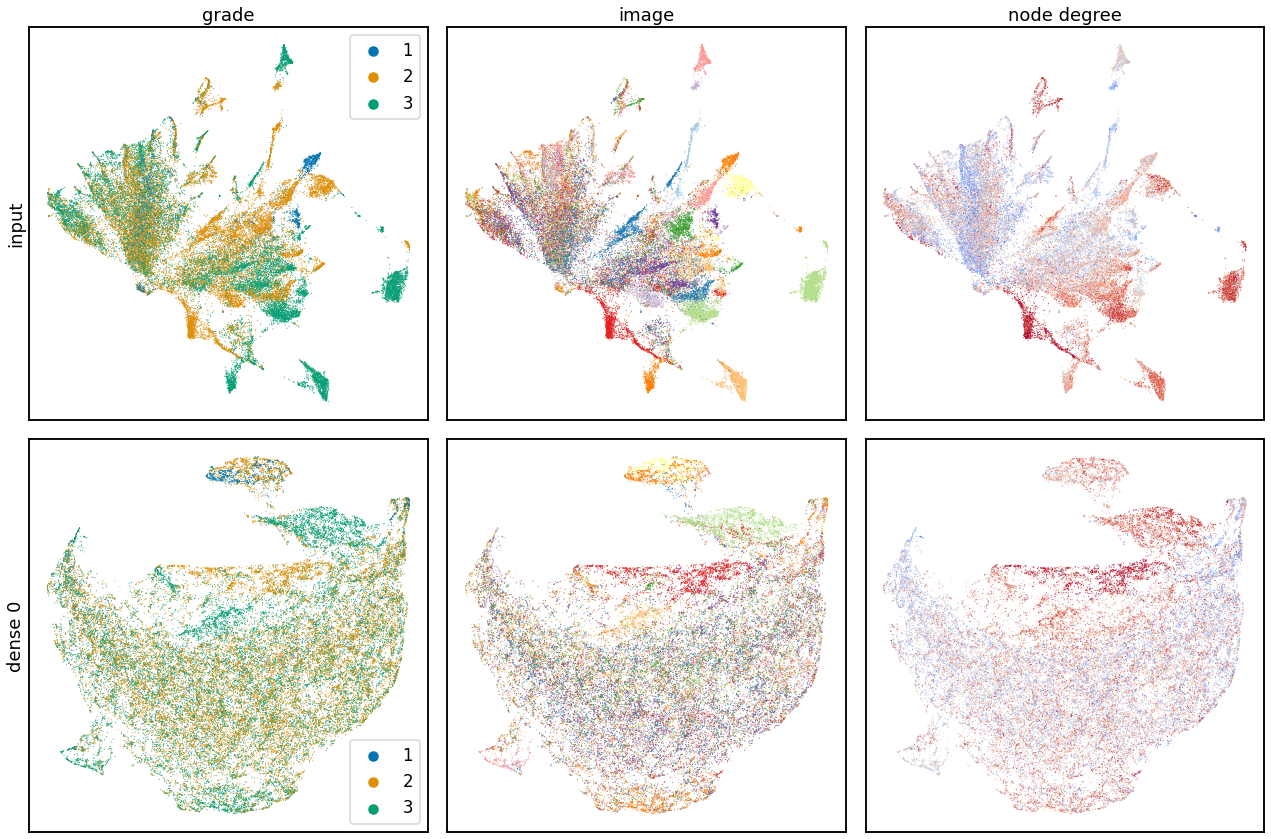

In [47]:
interpreter_mi.plot_umap_nodes(
    interpreter_mi.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        'input',
        'Layer_dense_feature_embedding0',
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='mb',
    save=dir_figures+"supp_mi_std_node_emb_refactored", 
)

In [38]:
layer_name = 'Layer_dense_feature_embedding0'
acts = interpreter_mi._get_node_embeddings(
        idx=interpreter_mi.img_keys_test,
        layers=[layer_name]
    )
h = acts[layer_name]
cells = np.concatenate(h)
cells = cells[:, cells.std(axis=0) > 0]
cells = (cells - cells.mean(axis=0)) / cells.std(axis=0)


images = np.concatenate([[id] * interpreter_mi.h[id].shape[0] for id in interpreter_mi.img_keys_test])

adata_cells = anndata.AnnData(
    cells,
    obs=pd.DataFrame({
        "images": images,
    })
)

adata_cells.obs['images'] = adata_cells.obs['images'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata_cells.obs['images_label'] = le.fit_transform(adata_cells.obs["images"])


from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata_cells.X, adata_cells.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata_cells.X, adata_cells.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images_cells.append(image_score)



from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata_cells.obs["images_label"], 
                                                           logreg.predict(adata_cells.X))
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images_cells.append(explained_variance_score_images)

r2_score_images = r2_score(adata_cells.obs["images_label"], 
                           logreg.predict(adata_cells.X), 
                           multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images_cells.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata_cells.obs["images_label"], logreg.predict(adata_cells.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images_cells.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.32336861695940444
Variance explained - images : -0.38605418477981934
R2 score - images: -0.38610085467874433
R2 score linreg - images: 0.07243300163809212


/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
sc.pp.neighbors(adata_cells, n_neighbors=n_neighbors)
sc.tl.pca(adata_cells)

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata_cells, label_key=label_key)
graph_connectivity_cells.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata_cells, batch_key=label_key)
ilisi_cells_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.7222401499857823
/tmp/lisi_a3zxhpn2/input.mtx /tmp/lisi_a3zxhpn2/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.11722387005080456


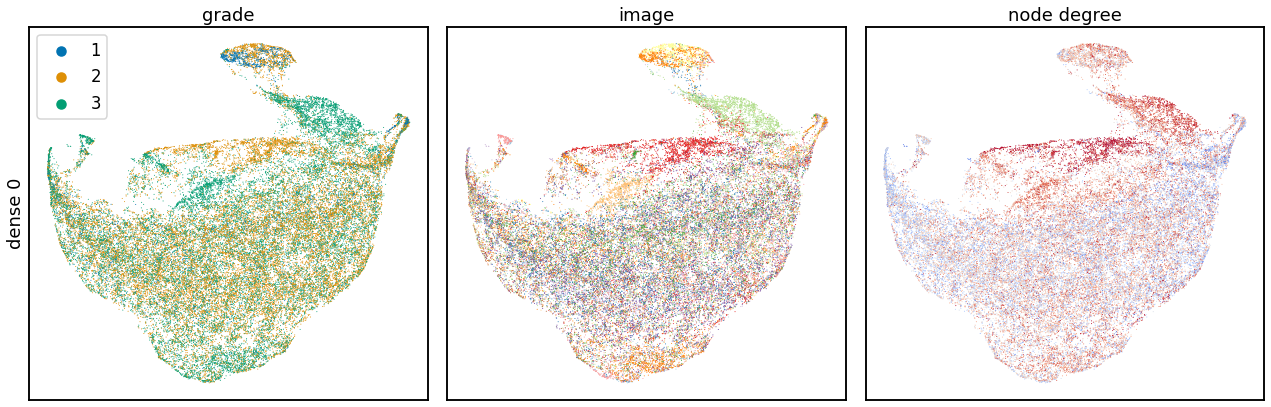

In [40]:
n_neighbors=50
layer_name = 'Layer_dense_feature_embedding0'
umap_emb, hue = interpreter_mi.plot_umap_nodes(
    interpreter_mi.img_keys_test,
    plot_types = ['grade', 'images', 'degree'],
    layer_names=[
        layer_name,
    ],
    panel_width=6.0,
    panel_height=6.0,
    data_key='mb',
    return_embeddings=True,
    n_neighbors=n_neighbors,
)

In [41]:
adata = anndata.AnnData(
    umap_emb,
    obs=pd.DataFrame({
        "images": hue["images"],
        "grade": hue["grade"]
    })
)

adata.obs['images'] = adata.obs['images'].astype('category')
adata.obs['grade'] = adata.obs['grade'].astype('category')
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
adata.obs['images_label'] = le.fit_transform(adata.obs["images"])


sc.pp.neighbors(adata, n_neighbors=n_neighbors)
sc.tl.pca(adata)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [42]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(adata.X, adata.obs["images_label"])

print(f"{layer_name=}")
image_score = logreg.score(adata.X, adata.obs["images_label"])
print(f'Images training score: {image_score}')
predict_score_images.append(image_score)


from sklearn.linear_model import LogisticRegression
logreg_grade = LogisticRegression()
logreg_grade.fit(adata.X, adata.obs["grade"])

grade_score = logreg_grade.score(adata.X, adata.obs["grade"])
print(f'Grade training score: {grade_score}')
predict_score_grade.append(grade_score)


from sklearn.metrics import explained_variance_score, r2_score

explained_variance_score_images = explained_variance_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='variance_weighted')
print(f'Variance explained - images : {explained_variance_score_images}')
varian_explained_images.append(explained_variance_score_images)

r2_score_images = r2_score(adata.obs["images_label"], logreg.predict(adata.X), multioutput='uniform_average')
print(f'R2 score - images: {r2_score_images}')
r2_images.append(r2_score_images)

from scipy import sparse, stats

r2_score_linreg = stats.linregress(adata.obs["images_label"], logreg.predict(adata.X))[2] ** 2
print(f'R2 score linreg - images: {r2_score_linreg}')
r2_linreg_images.append(r2_score_linreg)

/home/iterm/mayar.ali/anaconda3/envs/tissue/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


layer_name='Layer_dense_feature_embedding0'
Images training score: 0.14951727346748866
Grade training score: 0.5217168779806909
Variance explained - images : -0.7090884589995927
R2 score - images: -0.8169615791524054
R2 score linreg - images: 0.0234287417144788


In [43]:
### n=50
label_key="grade"
graph_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_grade.append(graph_metric)

print(f'graph connectivity metric {layer_name} layer - {label_key} = {graph_metric}')

label_key="images"
images_metric = scib.metrics.graph_connectivity(adata, label_key=label_key)
graph_conn_images.append(images_metric)
print(f'graph connectivity metric {layer_name} layer - {label_key} = {images_metric}')

label_key="grade"
grade_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_grade.append(grade_metric)
print(f'ilisi graph metric {layer_name} layer - {label_key} = {grade_metric}')

label_key="images"
images_metric = scib.metrics.ilisi_graph(adata, batch_key=label_key)
ilsi_graph_images.append(images_metric)
print(f'ilisi graph  metric {layer_name} layer - {label_key} = {images_metric}')

graph connectivity metric Layer_dense_feature_embedding0 layer - grade = 0.7477450389491844
graph connectivity metric Layer_dense_feature_embedding0 layer - images = 0.19234194063925045
/tmp/lisi_cy5719o2/input.mtx /tmp/lisi_cy5719o2/
ilisi graph metric Layer_dense_feature_embedding0 layer - grade = 0.4679737127857859
/tmp/lisi_dmyn4vmr/input.mtx /tmp/lisi_dmyn4vmr/
ilisi graph  metric Layer_dense_feature_embedding0 layer - images = 0.15029269416125635


#### Plot integration metrics

In [38]:
sns.set_palette('colorblind')

In [49]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib 
matplotlib.rcParams.update({'font.size': 10})
plt.rc('axes', labelsize=10)

In [53]:
df_metrics

model   cv  prediction_score  variance_explained  r2_score  \
0   input  cv0          0.741724            0.500852  0.500494   
1   GCNSS  cv0          0.664534            0.341974  0.341152   
2   input  cv1          0.741724            0.500852  0.500494   
3   GCNSS  cv1          0.720507            0.424802  0.421858   
4   input  cv2          0.741724            0.500852  0.500494   
5   GCNSS  cv2          0.697197            0.401234  0.396608   
6     GCN  cv0          0.966104            0.950230  0.950193   
7     GCN  cv1          0.961568            0.925130  0.925125   
8     GCN  cv2          0.963127            0.933390  0.933390   
9      MI  cv0          0.323369           -0.386054 -0.386101   
10     MI  cv1          0.323369           -0.386054 -0.386101   
11     MI  cv2          0.323369           -0.386054 -0.386101   

    graph_connectivity     ilisi  1 - graph_connectivity  
0             0.955135  0.066359                0.044865  
1             0.859219  0.061730                0.140781  
2             0.955135  0.066359                0.044865  
3             0.889129  0.048565                0.110871  
4             0.955135  0.066359                0.044865  
5             0.901770  0.046526                0.098230  
6             0.989234  0.001559                0.010766  
7             0.990207  0.004132                0.009793  
8             0.987930  0.002295                0.012070  
9             0.722240  0.117224                0.277760  
10            0.722240  0.117224                0.277760  
11            0.722240  0.117224                0.277760

In [87]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib 
matplotlib.rcParams.update({'font.size': 12})
plt.rc('axes', labelsize=12)

In [89]:
df_metrics

model   cv  prediction_score  variance_explained  r2_score  \
0   input  cv0          0.741724            0.500852  0.500494   
1   GCNSS  cv0          0.664534            0.341974  0.341152   
2   input  cv1          0.741724            0.500852  0.500494   
3   GCNSS  cv1          0.720507            0.424802  0.421858   
4   input  cv2          0.741724            0.500852  0.500494   
5   GCNSS  cv2          0.697197            0.401234  0.396608   
6     GCN  cv0          0.966104            0.950230  0.950193   
7     GCN  cv1          0.961568            0.925130  0.925125   
8     GCN  cv2          0.963127            0.933390  0.933390   
9      MI  cv0          0.323369           -0.386054 -0.386101   
10     MI  cv1          0.323369           -0.386054 -0.386101   
11     MI  cv2          0.323369           -0.386054 -0.386101   

    graph_connectivity     ilisi  1 - graph_connectivity  
0             0.955135  0.066359                0.044865  
1             0.859219  0.061730                0.140781  
2             0.955135  0.066359                0.044865  
3             0.889129  0.048565                0.110871  
4             0.955135  0.066359                0.044865  
5             0.901770  0.046526                0.098230  
6             0.989234  0.001559                0.010766  
7             0.990207  0.004132                0.009793  
8             0.987930  0.002295                0.012070  
9             0.722240  0.117224                0.277760  
10            0.722240  0.117224                0.277760  
11            0.722240  0.117224                0.277760

In [98]:
 df_metrics[df_metrics["model"] == "input"].mean().values

array([0.74172386, 0.500852  , 0.50049423, 0.95513502, 0.06635923,
       0.04486498])

In [104]:
df_metrics_mean = pd.DataFrame(columns=["prediction_score", "variance_explained", "r2_score", "graph_connectivity", "ilisi", "1 - graph_connectivity"])
for model in ["input", "GCNSS", "GCN", "MI"]:
    df_metrics_mean.loc[model] = df_metrics[df_metrics["model"] == model].mean().values
df_metrics_mean.to_csv(dir_figures + "df_metrics_mean.csv")

<Figure size 1000x1000 with 0 Axes>

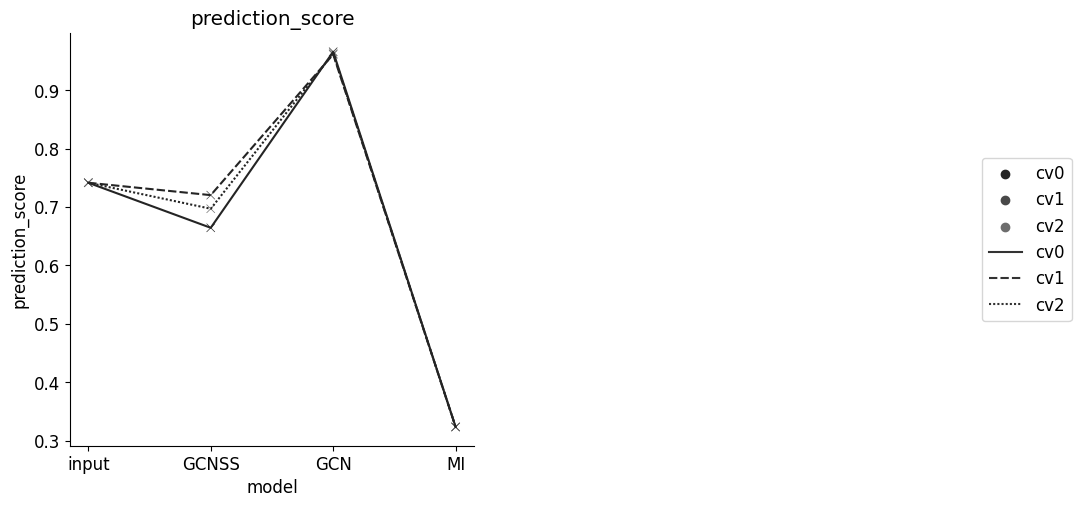

<Figure size 1000x1000 with 0 Axes>

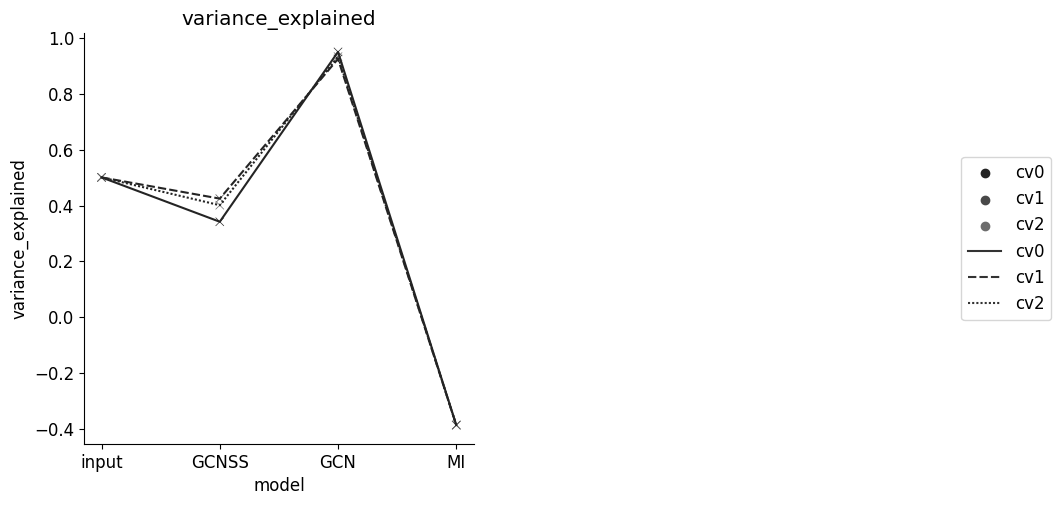

<Figure size 1000x1000 with 0 Axes>

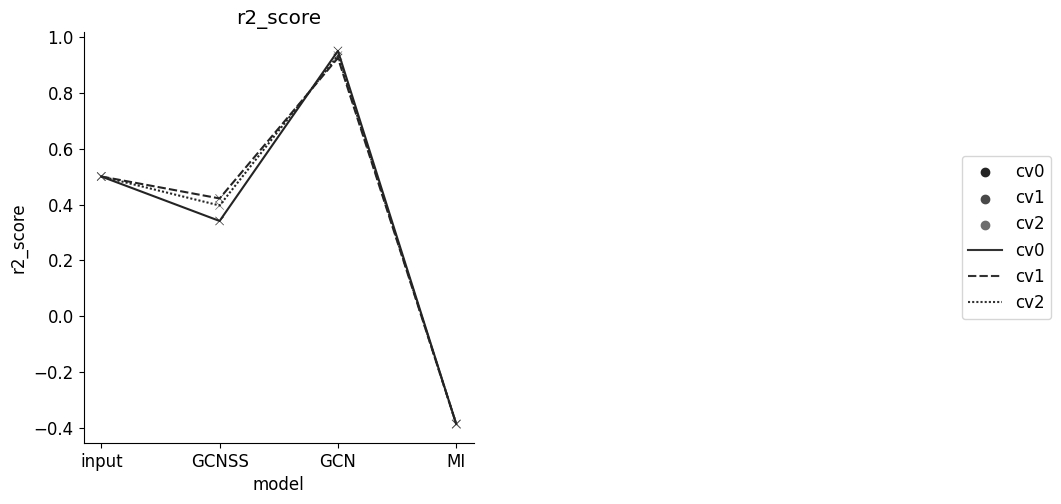

<Figure size 1000x1000 with 0 Axes>

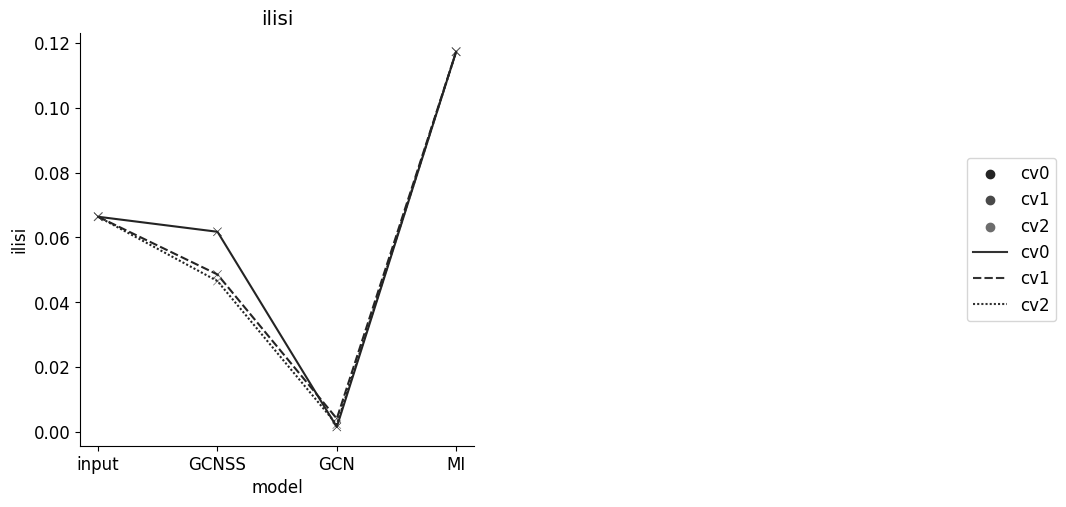

<Figure size 1000x1000 with 0 Axes>

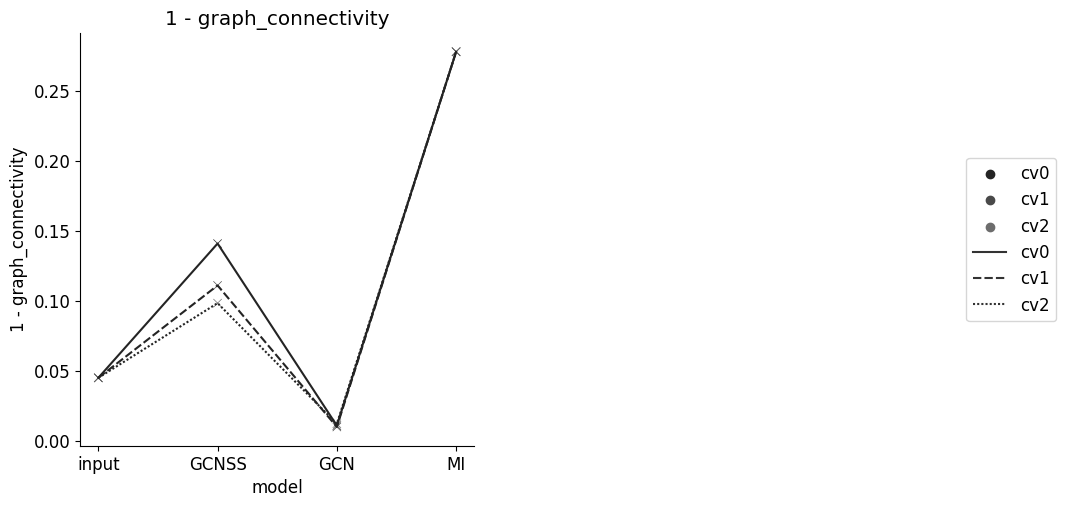

In [88]:
sns.set_palette('gray')

for i, metric in enumerate(["prediction_score","variance_explained","r2_score","ilisi","1 - graph_connectivity"]):
    plt.figure(figsize=(10,10))
    g = sns.FacetGrid(df_metrics, size=5)
    g.map(sns.scatterplot, "model", metric, hue=df_metrics["cv"], marker='x')
    g.map(sns.lineplot, "model", metric, style=df_metrics["cv"], linestyle='--')
    plt.legend(bbox_to_anchor=[2.5, 0.5], loc="right")
    plt.title(metric)
    plt.tight_layout()
#     plt.savefig(dir_figures + f"{metric}_cvs.pdf", bbox_inches = "tight")

    plt.show()
